Keine vorhandene CSV-Datei gefunden. Starten mit leeren Daten.
Daten in CSV-Datei gespeichert.


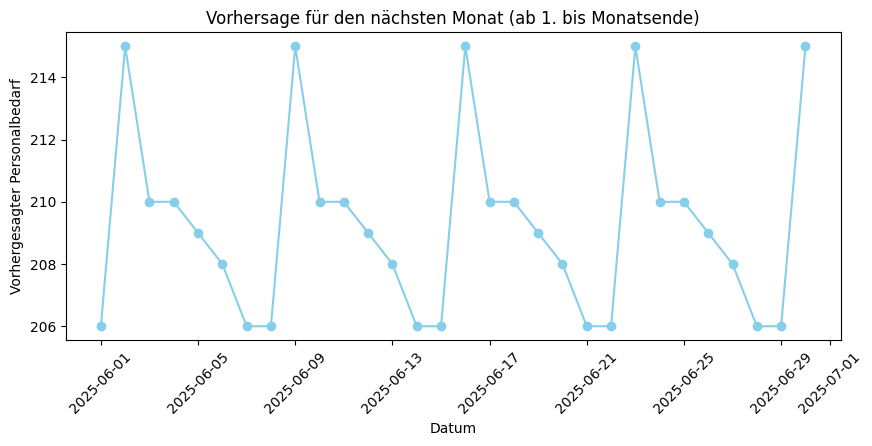

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar
import joblib
import tkinter as tk
from tkinter import ttk, messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os

# CSV-Dateipfad zur Speicherung der täglichen Daten
csv_file = r"..\daily_data.csv"

# Laden des Modells
model = joblib.load(r"..\models\fortgeschrittenes_model.pkl")

# Globale Variablen
daily_data = []  # Liste zur Speicherung der täglichen Daten

# Funktion zum Laden der täglichen Daten aus der CSV-Datei
def load_daily_data():
    global daily_data
    if os.path.exists(csv_file):
        daily_data = pd.read_csv(csv_file, parse_dates=['date']).to_dict('records')
        print(f"{len(daily_data)} Datensätze aus der CSV-Datei geladen.")
    else:
        print("Keine vorhandene CSV-Datei gefunden. Starten mit leeren Daten.")

# Funktion zum Speichern der täglichen Daten in die CSV-Datei
def save_daily_data():
    global daily_data
    df = pd.DataFrame(daily_data)
    df.to_csv(csv_file, index=False)
    print("Daten in CSV-Datei gespeichert.")

# Funktion zur Vorhersage für den nächsten Monat ab dem 1. bis zum Monatsende
def predict_next_month():
    try:
        if not daily_data:
            raise ValueError("Bitte geben Sie tägliche Daten ein, bevor Sie die Vorhersage durchführen.")
        
        # Prüfen, ob ausreichend Daten für die Vorhersage vorliegen (Daten vom 1. bis 15. des Monats)
        last_date = daily_data[-1]['date']  # Letztes Datum aus den täglichen Daten
        if last_date.day > 15:
            messagebox.showwarning("Warnung", "Daten nach dem 15. allein reichen nicht aus. Sie benötigen auch Daten vom 1. bis 15.")
            return
        
        # Vorhersage für den nächsten Monat
        predictions = []
        year = last_date.year if last_date.month < 12 else last_date.year + 1
        month = last_date.month + 1 if last_date.month < 12 else 1
        
        # Berechne das Startdatum (1. des nächsten Monats)
        start_date = datetime(year, month, 1)
        days_in_next_month = calendar.monthrange(year, month)[1]
        
        # Daten der letzten 7 Tage berechnen (zum Glätten der Schätzungen)
        last_7_days = daily_data[-7:] if len(daily_data) >= 7 else daily_data
        avg_calls = np.mean([entry['calls'] for entry in last_7_days])
        avg_n_duty = np.mean([entry['n_duty'] for entry in last_7_days])
        
        for i in range(days_in_next_month):  # Vorhersage für jeden Tag des nächsten Monats
            next_date = start_date + timedelta(days=i)
            day_of_week = next_date.weekday()

            # Saisonale Features für den nächsten Monat berechnen
            month_sin = np.sin(2 * np.pi * month / 12)
            month_cos = np.cos(2 * np.pi * month / 12)

            # Berechnung des 'calls_per_duty' Features
            calls_per_duty = avg_calls / avg_n_duty if avg_n_duty > 0 else 0  # Vermeidung von Division durch Null

            # Feature-DataFrame für die Vorhersage erstellen
            X_new = pd.DataFrame({
                'calls_per_duty': [calls_per_duty],
                'month_sin': [month_sin],
                'month_cos': [month_cos],
                'year': [year],
                'day_of_week': [day_of_week]
            })

            # Modellvorhersage durchführen
            predicted_need = model.predict(X_new)
            predicted_need = np.round(predicted_need[0]).astype(int)

            # Einfache Regel: Wenn die Anrufe kleiner oder gleich den Fahrern sind, setze die Vorhersage auf die Fahreranzahl
            if avg_calls <= avg_n_duty:
                predicted_need = avg_n_duty

            predictions.append({
                'date': next_date,
                'predicted_need': predicted_need
            })

        # DataFrame für die Vorhersagen erstellen
        predictions_df = pd.DataFrame(predictions)

        # Ergebnisse in der GUI anzeigen
        result_text.delete('1.0', tk.END)
        result_text.insert(tk.END, predictions_df[['date', 'predicted_need']].to_string(index=False))
        
        # Diagramm erstellen und anzeigen
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(predictions_df['date'], predictions_df['predicted_need'], marker='o', color='skyblue')
        ax.set_title(f"Vorhersage für den nächsten Monat (ab 1. bis Monatsende)")
        ax.set_xlabel("Datum")
        ax.set_ylabel("Vorhergesagter Personalbedarf")
        ax.tick_params(axis='x', rotation=45)

        # Diagramm in GUI einbetten
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.grid(row=5, column=0, columnspan=2, padx=10, pady=10)
        canvas.draw()

    except ValueError as e:
        messagebox.showerror("Fehler", str(e))
    except Exception as e:
        messagebox.showerror("Fehler", f"Ein unerwarteter Fehler ist aufgetreten: {str(e)}")
        print(f"Detaillierter Fehler: {e}")

# Funktion zum Hinzufügen von täglichen Daten
def add_daily_data():
    try:
        # Benutzereingaben lesen
        date_input = date_entry.get()
        calls_input = int(calls_entry.get())
        n_duty_input = int(n_duty_entry.get())
        
        # Datum in Datetime umwandeln
        date = pd.to_datetime(date_input)

        # Daten zur täglichen Datenliste hinzufügen
        daily_data.append({
            'date': date,
            'calls': calls_input,
            'n_duty': n_duty_input
        })
        
        # Neue Daten in die CSV-Datei speichern
        save_daily_data()
        
        # Eingabefelder zurücksetzen
        date_entry.delete(0, tk.END)
        calls_entry.delete(0, tk.END)
        n_duty_entry.delete(0, tk.END)
        
        messagebox.showinfo("Erfolg", "Daten erfolgreich hinzugefügt und gespeichert.")
        
    except ValueError as e:
        messagebox.showerror("Fehler", f"Ungültige Eingaben: {str(e)}")
    except Exception as e:
        messagebox.showerror("Fehler", f"Ein unerwarteter Fehler ist aufgetreten: {str(e)}")
        print(f"Detaillierter Fehler: {e}")

# GUI erstellen
root = tk.Tk()
root.title("Monatsvorhersage für Einsatzfahrer")

# Eingabefelder
ttk.Label(root, text="Datum (YYYY-MM-DD):").grid(row=0, column=0, padx=5, pady=5)
date_entry = ttk.Entry(root)
date_entry.grid(row=0, column=1, padx=5, pady=5)

ttk.Label(root, text="Anzahl der Anrufe:").grid(row=1, column=0, padx=5, pady=5)
calls_entry = ttk.Entry(root)
calls_entry.grid(row=1, column=1, padx=5, pady=5)

ttk.Label(root, text="Anzahl der Fahrer im Dienst:").grid(row=2, column=0, padx=5, pady=5)
n_duty_entry = ttk.Entry(root)
n_duty_entry.grid(row=2, column=1, padx=5, pady=5)

# Button zum Hinzufügen der täglichen Daten
ttk.Button(root, text="Tägliche Daten hinzufügen", command=add_daily_data).grid(row=3, column=0, columnspan=2, pady=10)

# Vorhersage-Button
ttk.Button(root, text="Vorhersage für nächsten Monat erstellen", command=predict_next_month).grid(row=4, column=0, columnspan=2, pady=10)

# Textfeld für Ergebnisse
result_text = tk.Text(root, height=10, width=50)
result_text.grid(row=6, column=0, columnspan=2, padx=10, pady=10)

# Beim Starten der Anwendung die CSV-Daten laden
load_daily_data()

# Hauptschleife der GUI starten
root.mainloop()
